# External Data

Each CASA distribution requires a minimal repository of binary data for CASA to function properly. This is contained in the [**casadata repository**](https://github.com/casangi/casadata) and bundled in to a [**casadata package**](https://pypi.org/project/casadata/) for modular CASA. The repository includes Measures Tables that deal with the Earth Orientation Parameters (EOPs), ephemeris data, antenna configurations, beam models, and calibration corrections. 


In [ ]:
# this page contains live examples of casa usage from the following installation
!pip install --extra-index-url https://test.pypi.org/simple/ casadata==0.0.1rc18  > /dev/null
!pip install casatools==6.3.0.48 > /dev/null

## Locating the Data Directory

(**TBD** - add versioning to the data folder download)

The casadata package contains an internal ```__data__``` subdirectory to hold the tables.


In [ ]:
# get the location of the data directory within the installation package
from casadata import get_data_dir
print(get_data_dir())

/usr/local/lib/python3.7/dist-packages/casadata/__data__/


In [ ]:
# see what's in it
!ls /usr/local/lib/python3.7/dist-packages/casadata/__data__/

README.txt


The initial installation of the casadata package leaves the ```__data__``` folder empty.  This is because the data tables are quite large and not suitable for Python package distribution. The ```__data__``` folder must be populated after installation (not necessary with monolithic casa tarball which already has the data populated).

In [ ]:
# populate the data folder
from casadata import pull_data
pull_data()

!ls /usr/local/lib/python3.7/dist-packages/casadata/__data__/

alma	  demo	       ephemerides  gui   README.txt
catalogs  dish_models  geodetic     nrao  telescope_layout


With the ```__data__``` folder populated, we can now import casatools and verify it successfully found our data

In [ ]:
# the utils tool is what is commonly known as ctsys
from casatools import utils

ctsys = utils.utils()
print(ctsys.getpath())


['/usr/local/lib/python3.7/dist-packages/casadata/__data__']


<div class="alert alert-info">
**NOTE**: CASA may be configured to look for casadata anywhere, not just the built in package location. See the [configuration section](../api/configuration.rst) in the API
</div>

In [ ]:
# populate some custom location with the data folder contents
pull_data('./my_other_data')

!ls ./my_other_data

alma	  demo	       ephemerides  gui   telescope_layout
catalogs  dish_models  geodetic     nrao


<div class="alert alert-warning">
**WARNING**: If you are using python-casacore directly (outside of CASA), you will need to set your .casarc file to point to wherever you installed casadata and/or populated a data folder
</div>

In [ ]:
# tell casacore where to find casadata
from casadata import set_casacore_path
data_path = get_data_dir()
set_casacore_path(data_path)

!more ~/.casarc

writing /root/.casarc...
measures.directory: /usr/local/lib/python3.7/dist-packages/casadata/__data__


## Updating the Data Directory

Most of the data tables (such as beam models, antenna and Jy/K correction tables, and the antenna configuration files for the CASA simulator) are versioned by CASA release and do not need to change. However, the **Casacore Measures** tables (ie *geodetic* subdirectory) must be updated frequently after release.

It is important to know what version/date of Measures data is currently populated. This can be done by looking at the current IERSPredict table

(**TBD** - maybe make an API function for this?)

In [ ]:
# view the current measures data date
from casadata import table_open
xds = table_open(get_data_dir()+'/geodetic/IERSpredict')

print(xds.attrs['vs_date'])

2021/08/15/15:00


In [ ]:
# see if something newer is available
from casadata import measures_available
versions = measures_available()

print(versions[-5:])

['20210828-160001', '20210829-160001', '20210830-160001', '20210831-160001', '20210901-160001']


In [ ]:
# there is, so lets get the latest
from casadata import measures_update
measures_update(version=versions[-1])

connecting to ftp.astron.nl ...
downloading data from ASTRON server ...


In [ ]:
# verify that it worked
xds = table_open(get_data_dir()+'/geodetic/IERSpredict')
print(xds.attrs['vs_date'])

2021/09/01/15:00


<div class="alert alert-info">
**NOTE**: If CASA is configured to look for casadata outside of the package installation location (see the [configuration section](../api/configuration.rst)), then make sure to update the right location
</div>

In [ ]:
xds = table_open('./my_other_data/geodetic/IERSpredict')
print(xds.attrs['vs_date'])

2021/08/15/15:00


In [ ]:
measures_update('./my_other_data/', version=versions[-1])

connecting to ftp.astron.nl ...
downloading data from ASTRON server ...


In [ ]:
xds = table_open('./my_other_data/geodetic/IERSpredict')
print(xds.attrs['vs_date'])

2021/09/01/15:00


## Split Data Locations

Often times with site installations of CASA, it is convenient to leave a bulk of the data contents in a single shared location that is write-protected.  At runtime, users can pull the latest Measures data (small) to their local CASA working directory.  This scheme gives users complete control over what version / update frequency of Measures data they prefer without the inefficiency of storing copies of the complete casadata contents for every user.

To make use of this, we need to split the location of the measures data (i.e. geodetic folder) from the rest of the casadata contents.  The [configuration section](../api/configuration.rst) details how to specify multiple locations for CASA runtime data.  Let's assume we've configured CASA to look for data in two locations: ```./shared_data``` and ```./my_measures_data``` 

In [ ]:
# SYSTEM ADMIN - one-time setup of the shared_data folder
from casadata import pull_data
pull_data('./shared_data')

In [ ]:
# USERS - every time you run CASA
from casadata import measures_update
measures_update('./my_measures_data')

connecting to ftp.astron.nl ...
downloading data from ASTRON server ...


<div class="alert alert-info">
**NOTE**: Users can do this automatically by putting the preceding lines in config.py
</div>

An example config.py that sets up this split data location is as follows:

```
$: cat config.py

from casatools import measures_update
measures_update('./my_measures_data')

datapath=["./shared_data"]
rundata="./my_measures_data"
```

Now we have the large data in a static shared location for everyone to point to, and just the small daily updates to the Measures data stored in individual users directories.

In [ ]:
!du -h -d 0 ./shared_data
!du -h -d 0 ./my_measures_data

543M	./shared_data
26M	./my_measures_data


Remember when using python-casacore directly outside of CASA, a one-time setup of the proper .casarc is also needed to point to the individual measures data folder.

In [ ]:
# USERS of python-casacore only - one-time setup of .casarc
from casadata import set_casacore_path
set_casacore_path('./my_measures_data')

!more ~/.casarc

found existing .casarc...
writing /root/.casarc...
measures.directory: /content/my_measures_data


## Data Directory Contents

### Casacore Measures

The casacore Measures tables are needed to perform accurate conversions of reference frames.  Casacore infrastructure includes classes to handle physical quantities with a reference frame, so-called *Measures*. Each type of Measure has its own distinct class in casacore which is derived from the Measure base class. One of the main functionalilties provided by casacore w.r.t. Measures, is the conversion of Measures from one reference frame to another using the MeasConvert classes.

Many of the spectral, spatial, and time reference frames are time-dependent and require the knowledge of the outcome of ongoing monitoring measurements of properties of the Earth and astronomical objects by certain service observatories. This data is tabulated in a number of tables (*Measures Tables*) which are stored in the casadata repository in the subdirectory ```geodetic```. A snapshot of this repository is included in each tarball distribution of CASA and in the casadata module for CASA6+.

Measures tables are updated daily based on the refinement of the geodetic information from the relevant services like the International Earth Rotation and Reference Systems Service (IERS). Strictly speaking, the Measures tables are part of the casacore infrastructure which is developed by NRAO, ESO, NAOJ, CSIRO, and ASTRON. In order to keep the repository consistent between the partners, the Measures tables are initially created at a single institution (ASTRON) and then copied into the NRAO casadata repository from which all CASA users can retrieve them. As of March 2020, the update of the NRAO CASA copy of the Measures tables in ```geodetic``` and the planetary ephemerides in directory ```ephemerides``` takes place every day between 18 h UTC and 19 h UTC via two redundant servers at ESO (Garching).

**CASA releases need to be updated with recent Measures tables** (see [above](#Updating-the-Data-Directory)).  For observatory use, the update period should not be longer than weekly in order to have the EOPs up-to-date for upcoming observations. The shortest reasonable update interval is daily. For offline data analysis use, the update period should not be longer than monthly. Weekly update is recommended. 

Legacy installations processing old data do not have to be updated because the relevant contents of the Measures Tables is not changing anymore for the more distant past.

The following list describes the individual Tables in subdirectory ```geodetic```:

* **IERSeop2000:**    The IERS EOP2000C04_05 Earth Orientation Parameters 
using the precession/nutation model \"IAU2000\" (files eopc04_IAU2000.xx)
* **IERSeop97**:    The IERS EOPC04_05 Earth Orientation Parameters using the precession/nutation model \"IAU 1980\" (files eopc04.xx)
* **IERSpredict:** IERS Earth Orientation Data predicted from NEOS (from file <ftp://ftp.iers.org/products/eop/rapid/daily/finals.daily>)
* **IGRF:**    International Geomagnetic Reference Field Schmidt [semi-normalised spherical harmonic coefficients](https://www.ngdc.noaa.gov/IAGA/vmod/coeffs/). (Note that this still uses IGRF12. An update to IGRF13 is underway.)
* IMF (not a Measures Table proper, access not integreated in Measures framework):    Historical interplanetary magnetic field data until MJD 52618 (December 2002).
* KpApF107 (not a Measures Table proper, access not integreated in Measures framework): Historical geomagnetic and solar activity indices until MJD 54921 (April 2009)
* **Observatories:** Table of the official locations of radio observatories. Maintained by the CASA consortium.
* SCHED_locations (not a Measures Table proper, access not integreated in Measures framework):    VLBI station locations
* **TAI_UTC:** TAI_UTC difference (i.e. leap second information) obtained from USNO


Measures Tables in the directory ```ephemerides```:

* **DE200**:    Historical JPL Planetary ephemeris DE200 used for Astronomical Almanach from 1984 to 2003 (from <ftp://ssd.jpl.nasa.gov/pub/eph/planets/ascii/de200>)
* **DE405**:    JPL Planetary ephemeris DE405; includes nutations and librations; referred to the ICRS (from <ftp://ssd.jpl.nasa.gov/pub/eph/planets/ascii/de405>)



We can open and inspect the contents of measures geodetic data directory using the casadata ```table_open``` function.  This returns an [**xarray dataset**](http://xarray.pydata.org/en/stable/user-guide/terminology.html) object (abbreviated as xds).

In [ ]:
from casadata import table_open, get_data_dir
xds = table_open(get_data_dir()+'/geodetic/IERSpredict')

print(xds)

<xarray.Dataset>
Dimensions:  (d0: 750)
Dimensions without coordinates: d0
Data variables: (12/13)
    MJD      (d0) float64 5.88e+04 5.88e+04 5.88e+04 ... 5.955e+04 5.955e+04
    X        (d0) float64 0.1556 0.1544 0.1532 0.1521 ... 0.1187 0.1167 0.113
    DX       (d0) float64 1.9e-05 3e-05 3e-05 ... 0.00792 0.007859 0.008015
    Y        (d0) float64 0.275 0.275 0.275 0.275 ... 0.2461 0.2463 0.2475
    DY       (d0) float64 2.1e-05 2.4e-05 2.6e-05 ... 0.01031 0.01031 0.01032
    DUT1     (d0) float64 -0.1629 -0.1634 -0.1639 ... -0.1249 -0.1252 -0.125
    ...       ...
    LOD      (d0) float64 0.0005854 0.0004804 0.0003702 ... 0.0 0.0 0.0
    DLOD     (d0) float64 2.7e-06 4.3e-06 3e-06 3.3e-06 ... 0.0 0.0 0.0 0.0
    DPSI     (d0) float64 -112.4 -112.5 -112.5 -112.3 -112.1 ... 0.0 0.0 0.0 0.0
    DDPSI    (d0) float64 0.174 0.086 0.086 0.086 0.081 ... 0.0 0.0 0.0 0.0 0.0
    DEPS     (d0) float64 -7.223 -7.307 -7.465 -7.583 -7.617 ... 0.0 0.0 0.0 0.0
    DDEPS    (d0) float64 0.183 

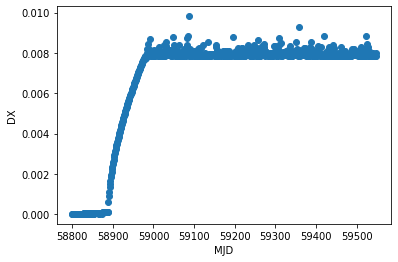

In [ ]:
xds.plot.scatter('MJD','DX')

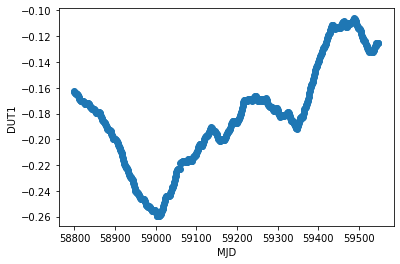

In [ ]:
xds.plot.scatter('MJD','DUT1')

Observe how the ```IERSpredict``` table updates over time

connecting to ftp.astron.nl ...
downloading data from ASTRON server ...
connecting to ftp.astron.nl ...
downloading data from ASTRON server ...


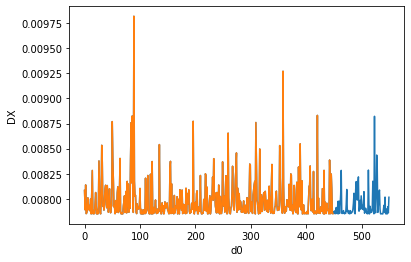

In [ ]:
from casadata import measures_update, measures_available
versions = measures_available()
measures_update('./older_measures', version=versions[0])
measures_update('./newer_measures', version=versions[-1])
old_xds = table_open('./older_measures/geodetic/IERSpredict')
new_xds = table_open('./newer_measures/geodetic/IERSpredict')
new_xds.DX[200:].plot()
old_xds.DX[200:].plot()

### Ephemeris Data 

The ephemeris tables hold a selection of the solar system objects from JPL-Horizons database.  The data tables are generated from the JPL Horizons system\'s on-line solar system data and ephemeris computation service ([https://ssd.jpl.nasa.gov/?horizons )](https://ssd.jpl.nasa.gov/?horizons "JPL Horizons"). These are primarily used to determine flux models for the solar system objects used in the **setjy** task.  These tables are stored as CASA tables in the casadata repository under ```ephemerides/JPL-Horizons```. The current ephemeris tables cover ephemerides until December 31, 2030 for those objects officially supported in **setjy**. 

Available objects, which include major planets, satellites, and asteroids, are: Mercury, **Venus**, **Mars**, **Jupiter**, Saturn, **Uranus**, **Neptune**, Pluto, **Io**, **Europa**, **Ganymede**, **Callisto**, **Titan**, **Ceres**, **Vesta**, **Pallas**, **Juno**, **Lutetia**, Sun and Moon (the objects in **bold** are those supported in \'Butler-JPL-Horizons 2012\' standard in **setjy**.). 

The format of the table name of these tables is *objectname*\_*startMJD*\_*endMJD*\_J2000.tab These tables required by **setjy** task are included in the data directory in the CASA distribution. The available tables can be listed by the following commands:


```
#In CASA6

CASA <1>: import glob

CASA <2>: jpldatapath=os.getenv('CASAPATH').split(' ')[0]+'/data/ephemerides/JPL-Horizons/*J2000.tab'

CASA <3>: glob.glob(jpldatapath)
```

The following data are retrieved from the JPL-Horizons system (the nubmer in the parentheses indicates the column number listed in the JPL-Horizons system). One should refer https://ssd.jpl.nasa.gov/?horizons_doc for the detailed descreption of each of these quantities.

Quantities | column no. | Unit/format | Descrition | column label
--- | --- | --- | --- | ---
Date | n.a. | YYYY-MM-DD | HH:MM | Date\_\_(UT)\_\_HR:MN
Astrometric RA & DEC | 1 | degrees | Astrometric RA and Dec with respect to the observer\'s location (GEOCETRIC) | R.A.\_(ICRF)\_DEC
Observer sub-long& sub-lat | 14 | degrees | Apparent planetodetic (\"geodetic\") longitude and latitude of the center of the target seen by the OBSERVER at print-time  | ob-lon, ob-lat
Solar sub-long & sub-lat | 15 | degrees | Apparent planetodetic (\"geodetic\") longitude and latitude of the Sun seen by the OBSERVER at print-time | Sl-lon, Sl-lat
North Pole Pos. ang. & dist. | 17 | degrees and arcseconds | Target\'s North Pole position angle and angular distance from the \"sub-observer\" point | NP.ang, NP.ds
Helio range & range rate | 19 | AU, km/s | Heliocentric range (r) and range-rate | (rdot) | r, rdot
Observer range & range rate | 20 | AU, km/s | Range (delta) and range-rate (deldot) of the target center with respect to the observer | delta, dedot
S-T-O angle | 24 | degrees | Sun-Target-Observer angle | S-T-O

The script ```request.py``` (located  in casatasks.private for CASA6) can be used to retrieve the ephemeris data from the JPL-Horizons system via e-mail (See also [Manipulate Ephemeris Objects page](ephemeris_data.ipynb#Manipulate-Ephemeris-Objects "Manipulate Ephemeris Objects")). Further, the saved email text file is converted to a CASA table format using JPLephem_reader2.


```
#In CASA6

CASA <5>: from casatasks.private import JPLephem_reader2 as jplreader

CASA <6>: outdict = jplreader.readJPLephem('titan-jpl-horizons-ephem.eml')
opened the file=titan-jpl-horizons-ephem.eml

CASA <7>: jplreader.ephem_dict_to_table(outdict,'Titan_test_ephem.tab')
Got nrows = 3653 from MJD
```

The converted table contains following columns.

Column name | unit/format | description
--- | --- | ---
MJD | day | modified Julian date
RA | degree | atrometric right acension in ICRF/J2000 frame
DEC | degree | astrometric declination in ICRF/J2000 frame
Rho | AU | Geocentric distance
RadVal | AU/d | Geocentric distance rate
NP_ang | degree | North pole position angle
NP_dist | degree | North pole angular distance
DiskLong | degree | Sub-observer longitude
DiskLat | degree | Sub-observer latitude
Sl_lon | degree | Sub-Solar longitude
Sl_lat | degree | Sub-Solar latitude
r | AU | heliocentric distance
rdot | km/s | heliocentric distance rate
phang | degree | phase angle




### Array Configuration

Array configuration files for various telescopes are distributed with each CASA release. These configuration files can be used to define the telescope for simulator tools and tasks. Currently, configuration files for the following telescopes are available in CASA:

-   ALMA / 12m Array
-   ALMA / 7m ACA
-   VLA
-   VLBA
-   Next-Generation VLA (reference design)
-   ATCA
-   MeerKat
-   PdBI (pre-NOEMA)
-   WSRT
-   SMA
-   Carma

The full list of antenna configurations can be found in the [CASA Guides on Simulations](https://casaguides.nrao.edu/index.php?title=Antenna_Configurations_Models_in_CASA_Cycle6).

One can also locate the directory with the configurations in the CASA distribution and then list the configuration files, using the following commands in CASA:

```
CASA <1>: print os.getenv('CASAPATH').split(' ')[0] + '/data/alma/simmos/'
/home/casa/packages/RHEL7/release/casa-release-5.4.0-68/data/alma/simmos/

CASA <2>: ls /home/casa/packages/RHEL6/release/casa-release-5.4.0-68/data/alma/simmos/
```

If a configuration file is not distributed with CASA but retrieved elsewhere, then the configuration file can be called by explicitly writing the full path to the location of the configuration file in the antennalist paramter of the simulator tasks.

<div class="alert alert-info">
**NOTE**: the most recent ALMA configuration files may not always be available in the most recent CASA version. ALMA configuration files for all cycles are available for download [here](https://almascience.nrao.edu/tools/casa-simulator). For the Next-Generation VLA reference design, the latest information can be found [here](https://ngvla.nrao.edu/page/tools).
</div>


## Examples

(**TBD** - put this in configuration section?)

1. Site installation of monolithic CASA with separate shared casadata directory outside of installation location

2. Individual installations of modular CASA pointing to shared casadata directory outside of installation location(s)
